In [7]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
import yfinance as yf
import pandas as pd

ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, back_adjust=True)

# Flatten MultiIndex columns if present (yfinance sometimes returns MultiIndex)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)
    
# Display data structure to verify
print(f"Data shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(f"\nFirst few rows:")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Data shape: (1006, 5)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']

First few rows:
Price           Close       High        Low       Open     Volume
Date                                                             
2020-01-02  72.468262  72.528582  71.223259  71.476600  135480400
2020-01-03  71.763733  72.523762  71.539345  71.696175  146322800
2020-01-06  72.335548  72.374154  70.634532  70.885464  118387200
2020-01-07  71.995346  72.600952  71.775781  72.345197  108872000
2020-01-08  73.153488  73.455087  71.698574  71.698574  132079200


In [8]:
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

In [10]:
data['Next_Close'] = data['Close'].shift(-1)

data = data.dropna()

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'MA200', 'RSI']
X = data[features]
y = data['Next_Close']

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         learning_rate=0.05,
                         early_stopping_rounds=50,
                         n_jobs=-1)

model.fit(X_train_scaled, y_train,
          eval_set=[(X_test_scaled, y_test)],
          verbose=False)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [12]:
predictions = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

Root Mean Squared Error (RMSE): $16.41


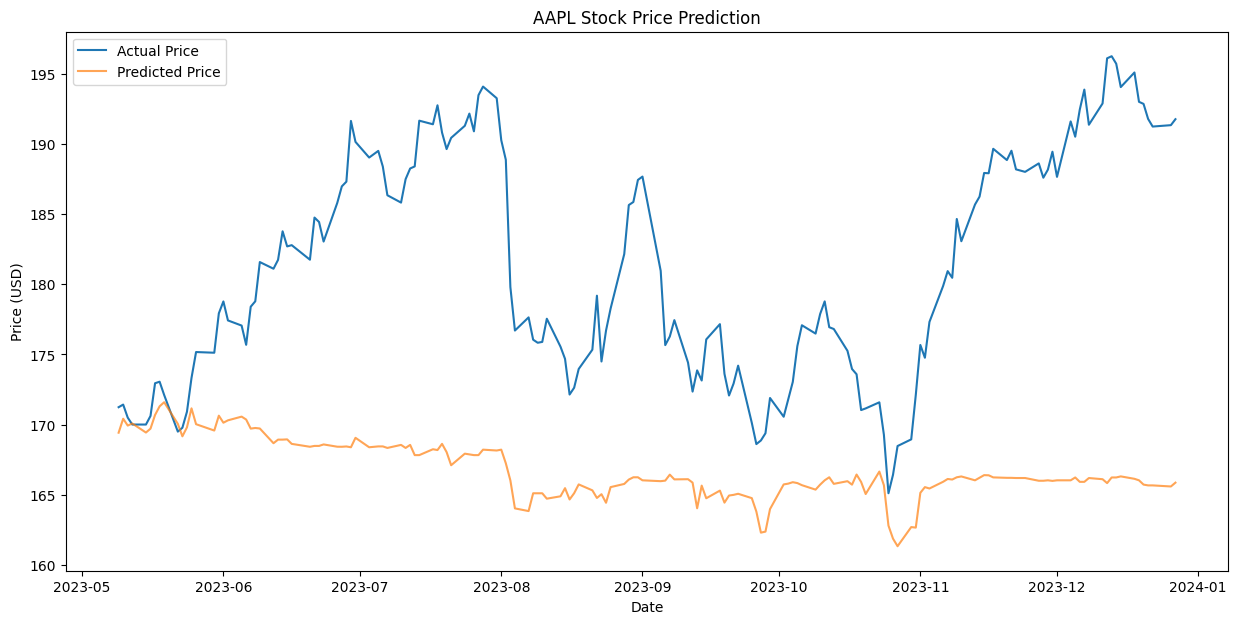

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, predictions, label='Predicted Price', alpha=0.7)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [14]:
import joblib

joblib.dump(model, "stock_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler have been saved successfully.")

Model and scaler have been saved successfully.
